# Introdução

Neste projeto foi coletadas letras de músicas do site "vagalume.com.br" com o objetivo de predizer a categoria de uma música baseada na letra. 

As etapas realizadas são:

- Limpeza do texto
- Criação de novas variáveis e manipulações gerais
- Análises descritivas
- Avaliação das categorias de músicas
- Criação do modelo
- Avaliação dos resultados

In [36]:
## Importando bibliotecas
import pandas as pd
import re
from unidecode import unidecode 
from spacy.lang.pt.stop_words import STOP_WORDS
from nltk.corpus import stopwords 
import nltk
import string
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from pandas_profiling import ProfileReport

In [37]:
# Lendo base
df = pd.read_pickle('input/songs.pkl')

In [38]:
# Checando quantidade de linhas e colunas
df.shape

(11030, 8)

In [78]:
## Funções para apoio de trativas de textos e criação de variáveis

# Limpa o texto
def transform_text(tokens):
    # html transform
    tokens = tokens.replace('<div data-plugin="googleTranslate" id="lyrics">', '').replace('</div>', '').replace('<br/>', " ")
    # stop words
    stop_words_ = STOP_WORDS.union(stopwords.words('portuguese'))
    stop_words = [unidecode(stop).lower() for stop in stop_words_]
    # Split to translate
    tokens = tokens.split()
    # Concatenate
    tokens = ' '.join(tokens)
    # Remove accents
    tokens = unidecode(tokens)
    # Remove https, mentions, special characters, single character
    tokens = re.sub("(@[A-Za-z0-9]+)|(_[A-Za-z0-9]+)|(\w+:\/\/\S+)|(\W_)", " ", tokens).lower()
    # Remove pontuaction
    tokens = re.sub('['+string.punctuation+']', '', tokens)
    # Substituting multiple spaces with single space
    tokens = re.sub(r'\s+', ' ', tokens, flags=re.I)
    # Remove digits
    tokens = ''.join([i for i in tokens if not i.isdigit()])
    # Remove all single characters
    tokens = re.sub(r'\s+[a-zA-Z]\s+', ' ', tokens)
    # Split
    tokens = tokens.split()
    # Stopwords
    tokens = [w for w in tokens if w not in stop_words]
    # Concatenate
    preprocessed_text = ' '.join(tokens)
    
    return preprocessed_text

# Retira palavras repetidas em uma sentença
def unique_list(l):
    ulist = []
    [ulist.append(x) for x in l if x not in ulist]
    return ulist

# Unificar classes
def classes(x):
    if x == 'Gospel/Religioso':
        return 'Religioso'
    elif x == 'Funk Carioca':
        return 'Funk'
    else:
        return x

## Limpeza do Texto

In [40]:
%%time
df['Transformed'] = df['lyrics'].apply(lambda x: transform_text(x))

CPU times: user 19.1 s, sys: 2.58 s, total: 21.7 s
Wall time: 23 s


## Manipulações gerais

In [41]:
# Considerando apenas músicas brasileiras
df_br = df[df['is_pt'] != 'Tradução ']

## Análise descritiva

Neste caso, tem-se as categorias consideradas pelo vagalume, um dos pontos a se observar seria a possibilidade de reduzir esse número de classes. Um exemplo de redução seria:

- Funk e Funk Carioca -> Funk

In [79]:
df_br_ = df_br[df_br['category'].isin(['Axé', 'Gospel/Religioso', 'Samba', 'Pagode', 'Pop/Rock', 'MPB', 'Hip Hop', 'Heavy Metal', 'Funk', 'Funk Carioca', 'Rock Alternativo', 'Sertanejo'])]
df_br_['category'] = df_br_['category'].apply(lambda x: classes(x))
df_br_['category'].unique()

array(['Axé', 'Funk', 'Religioso', 'Heavy Metal', 'Hip Hop', 'MPB',
       'Pagode', 'Pop/Rock', 'Rock Alternativo', 'Samba', 'Sertanejo'],
      dtype=object)

Abaixo temos as palavras com maior frequência em cada categoria.

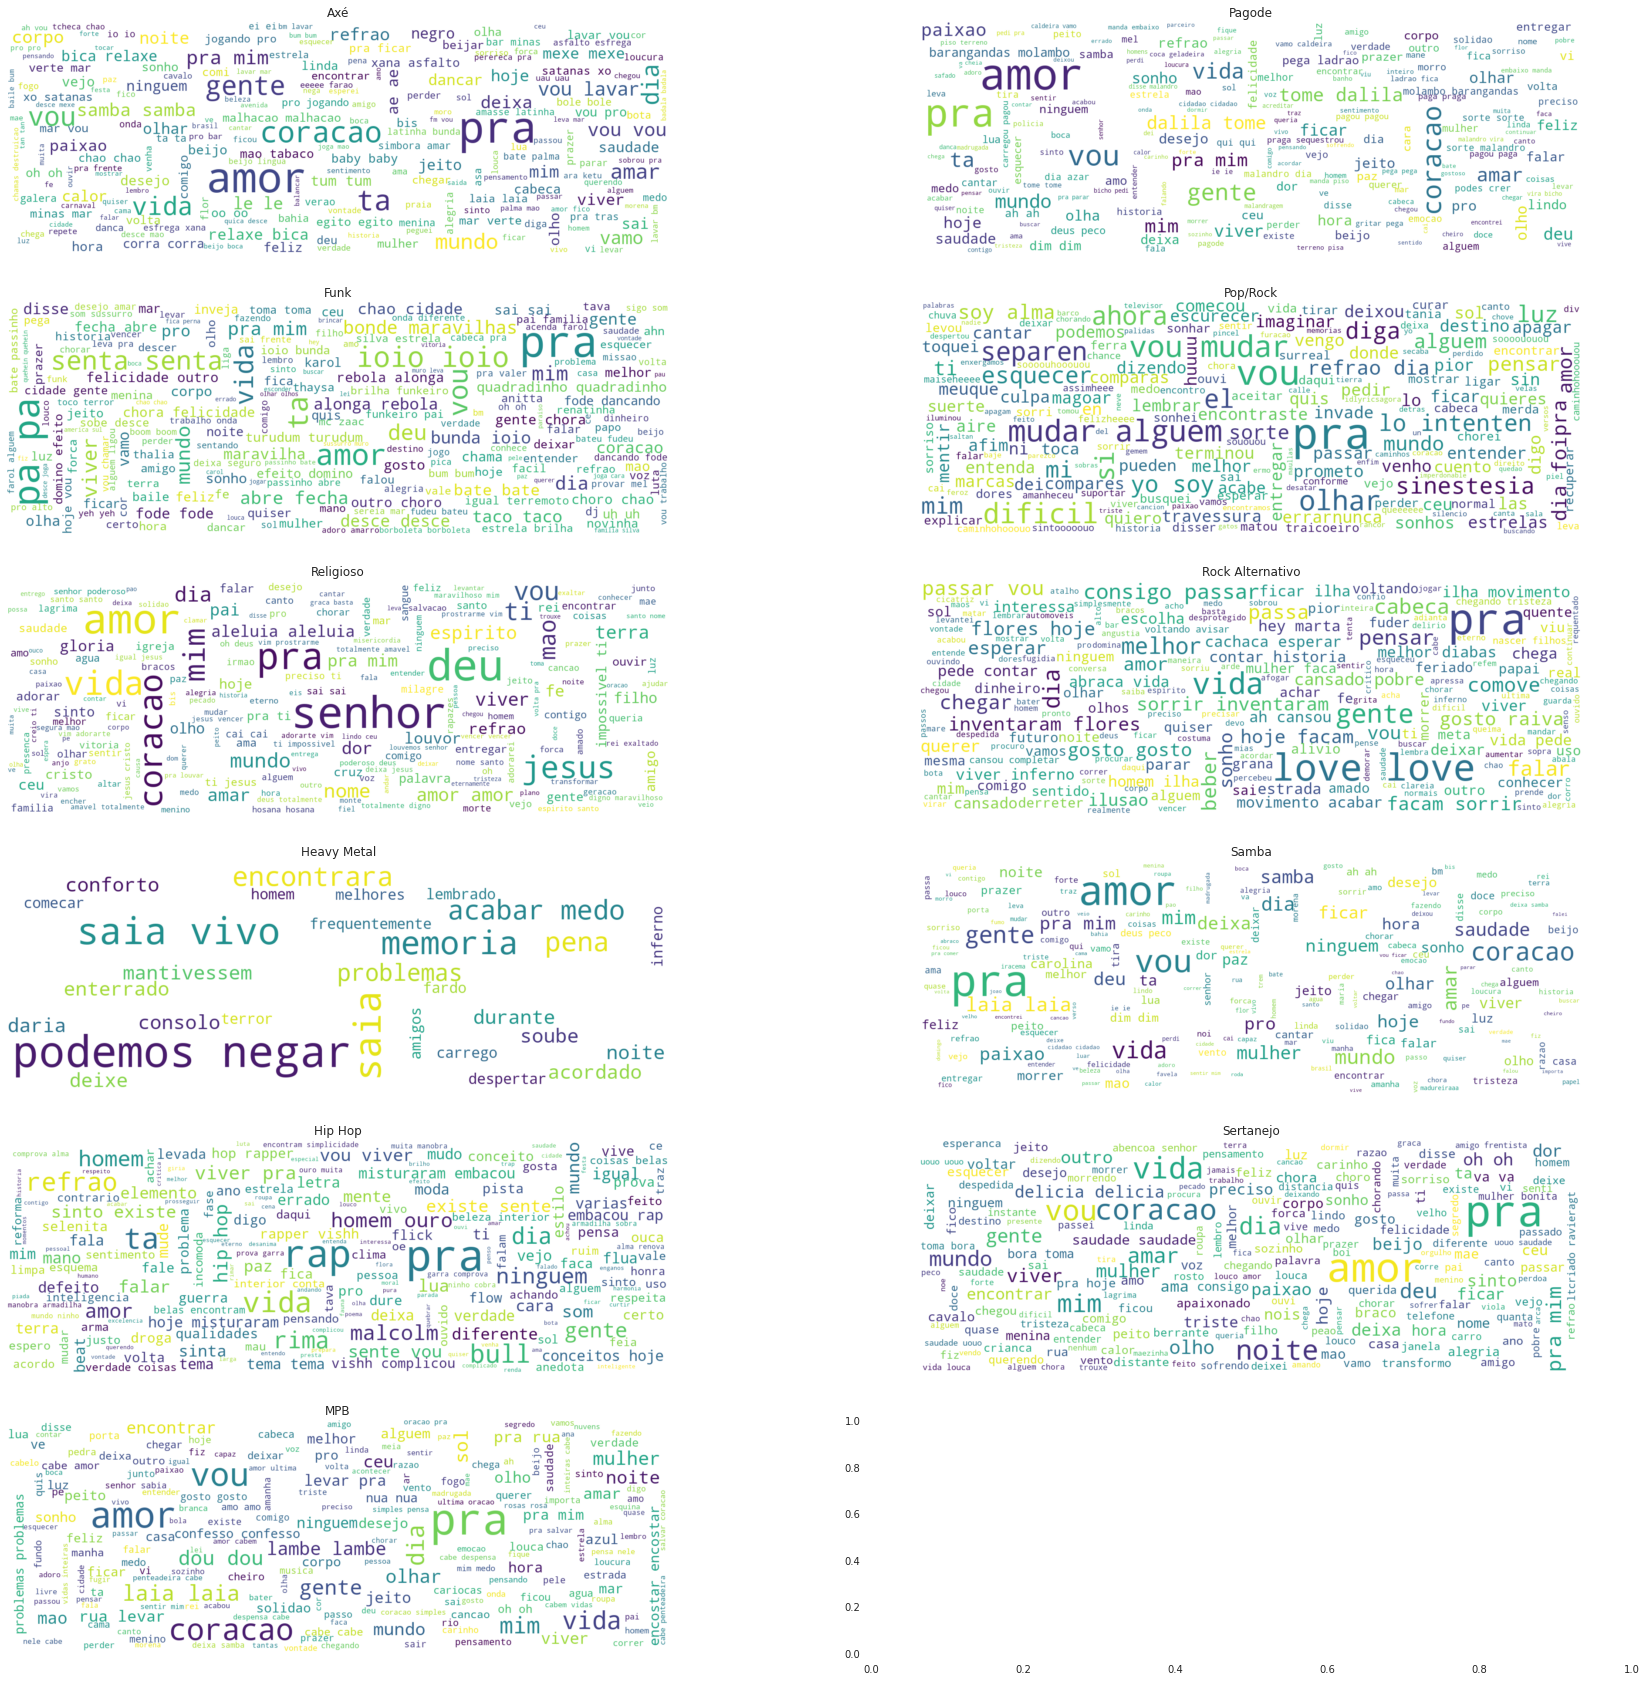

CPU times: user 14.9 s, sys: 1.64 s, total: 16.5 s
Wall time: 17.1 s


In [84]:
%%time
categorys = df_br_[df_br_['is_pt'] != "Tradução "]['category'].unique()
rows=6
cols=2
fig, ax = plt.subplots(rows, cols, figsize=(30,30))
row=0 
col=0 
for t in range(len(categorys)):
    text = " ".join(review for review in df_br_[(df_br_['is_pt'] != 'Tradução ') & (df_br_['category'] == categorys[t])]['Transformed'])
    try:
        ax[row][col].imshow(WordCloud(max_font_size=100,width = 1520, height = 535, background_color="white").generate(text), interpolation="bilinear")
        ax[row][col].set_title(categorys[t]) 
        ax[row][col].grid(False) 
        ax[row][col].axis("off")
    
        row=row+1
        if row==rows:
            row=0
            col=col+1
    except:
        pass
plt.show() 

Diferentes estilos de musicas ocasionam em uma maior ou menor diversidade de palavras? 

Para responder esta pergunta, foi realizada a redução de palavras duplicadas em cada letra. Para melhor exemplificação:

- Supõe-se que tem uma música que contém 30 palavras, sendo que 5 são duplicadas e outra música que contém 100 palavras e apenas 10 duplicadas. Retirando as duplicidades, tem - se 20 palavras na primeira e 80 na segunda. Neste caso, a segunda música contém uma diversidade maior de palavras utilizadas.

In [82]:
%%time
df_br_['Reduce'] = df_br_['Transformed'].apply(lambda x: ' '.join(unique_list(x.split())))
df_br_['len'] = df_br_['Reduce'].apply(lambda x: len(x))

CPU times: user 62.5 ms, sys: 15.6 ms, total: 78.1 ms
Wall time: 151 ms


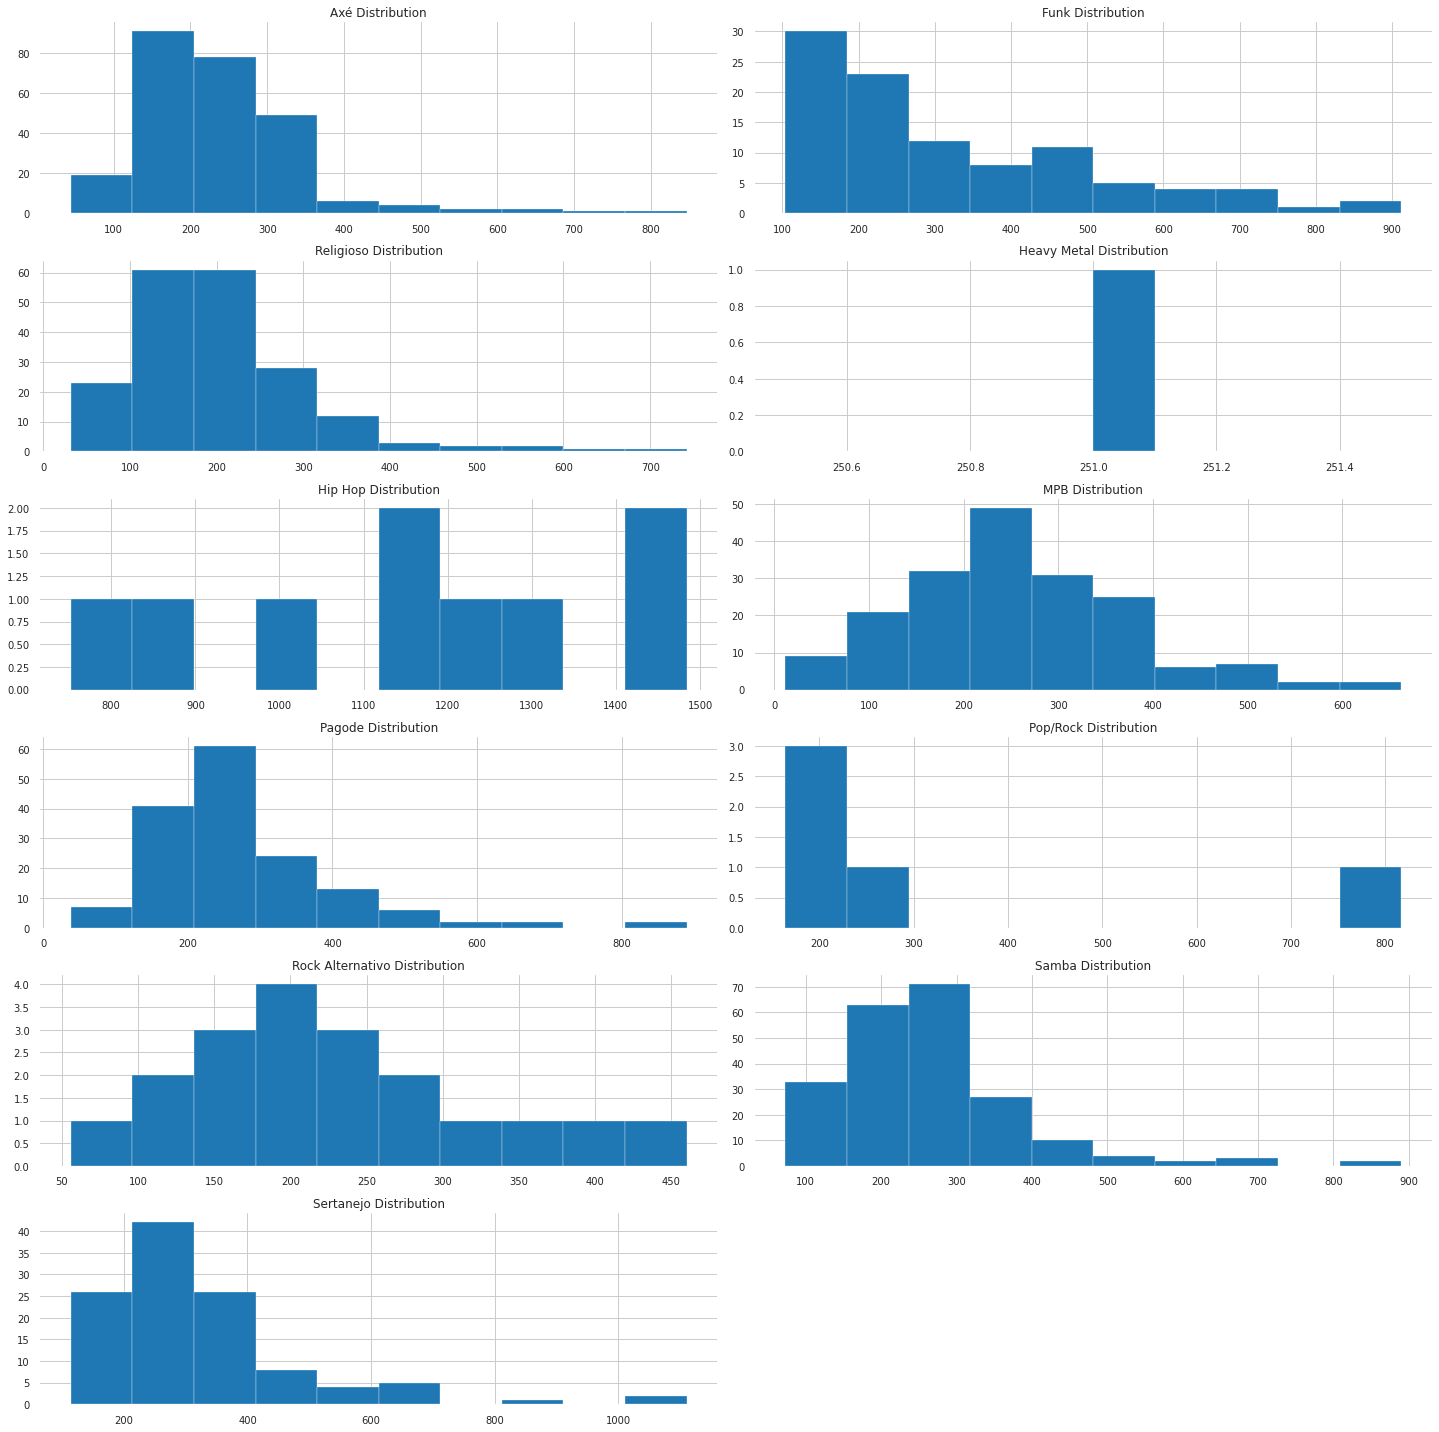

CPU times: user 4.5 s, sys: 625 ms, total: 5.12 s
Wall time: 5.28 s


In [97]:
%%time
categorys = df_br_[df_br_['is_pt'] != "Tradução "]['category'].unique()

import pandas as pd
import matplotlib.pyplot as plt

def draw_histograms(df, categorys, n_rows, n_cols):
    fig=plt.figure(figsize=(20,20))

    for i, var_name in enumerate(categorys):
        ax=fig.add_subplot(n_rows,n_cols,i+1)
        df[df['category']== var_name]['len'].hist(bins = 10, ax=ax)
        ax.set_title(var_name + " Distribution")
    fig.tight_layout()  # Improves appearance a bit.
    plt.show()

draw_histograms(df_br_, categorys, 6, 2)
    